<a href="https://colab.research.google.com/github/BolozR/DB_coursework/blob/master/dpa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import pywt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch

from google.colab import output 
import psutil as ps

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
!ls

100000	25000  50000  75000  drive  sample_data


In [ ]:
!ls -la /content/drive/MyDrive/dpav2/

In [ ]:
%%time
%%bash
for number in {25000..100000..25000}
do
tar -xzf /content/drive/MyDrive/dpav2/trace/$number.tar.gz
done

CPU times: user 162 ms, sys: 47.6 ms, total: 210 ms
Wall time: 37.8 s


In [ ]:
path = '/content/drive/MyDrive/dpav2/'
index_name = 'DPA_contest2_template_base_index_file'
trace_name = 'DPA_contest2_template_base_diff_vcc_a128_2009_12_23/'
trace_count = 100_000

In [ ]:
%%time
index_file = pd.read_csv(path+index_name, sep=' ', header=None, names=['key', 'plaintext', '??', 'filename'], nrows=trace_count)

CPU times: user 501 ms, sys: 136 ms, total: 637 ms
Wall time: 1.8 s


In [ ]:
%%time
key_bits = pd.read_csv(path+'key_bits', index_col=0, nrows=trace_count).to_numpy()

CPU times: user 1.89 s, sys: 206 ms, total: 2.09 s
Wall time: 4.28 s


In [ ]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        7.8G        234M        1.2M        4.6G        6.4G
Swap:            0B          0B          0B


In [ ]:
%%time
Trace = np.empty(shape=(trace_count, 3253), dtype=np.float32)
for i in range(25_000, trace_count + 25_000, 25_000):
  for j in range(i-25_000, i):
    Trace[j] = pd.read_csv('./{}/{}'.format(i, index_file.filename[j]), delimiter='\n', skiprows=24, header=None)[0].to_numpy()

CPU times: user 3min 6s, sys: 5.82 s, total: 3min 12s
Wall time: 3min 11s


In [ ]:
%%time
for i in range(0, trace_count, 100_000):
  scaler = StandardScaler()
  Trace[i:i+100_000] = scaler.fit_transform(Trace[i:i+100_000])
  del scaler

CPU times: user 6.7 s, sys: 1.17 s, total: 7.88 s
Wall time: 7.88 s


In [ ]:
%%time
waved = np.empty((Trace.shape[0], 817), dtype=np.float32)
for i in range(Trace.shape[0]):
  waved[i] = pywt.wavedec(Trace[i], 'sym3', level=2)[0]
del Trace

CPU times: user 9.32 s, sys: 39.7 ms, total: 9.36 s
Wall time: 9.34 s


torch.Size([133])


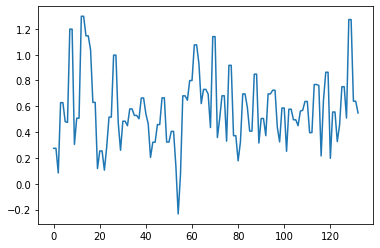

In [ ]:
conv1 = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=6, stride=2)
conv2 = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=6, stride=2)
avg = torch.nn.AvgPool1d(kernel_size=4, stride=3)
max = torch.nn.MaxPool1d(kernel_size=4, stride=2)
c = max(conv2(avg(conv1(torch.tensor(Trace[0]).unsqueeze(0).unsqueeze(0))))).squeeze(0).squeeze(0)
print(c.shape)
plt.plot(range(len(c)), c.detach().numpy())

In [ ]:
Trace_train_s, Trace_test_s, key_train_s, key_test_s = train_test_split(Trace, key_bits[:,0], test_size=0.20, random_state=0, stratify=key_bits[:,0])

In [ ]:
key_train_s.mean()

0.499475

In [ ]:
key_test_s.mean()

0.49945

In [ ]:
class DpaNet(torch.nn.Module):
    def __init__(self):
        super(DpaNet, self).__init__()
        
        self.layers = torch.nn.Sequential(
        torch.nn.Linear(3253, 1627),
        torch.nn.SELU(),
        torch.nn.Linear(1627, 814),
        torch.nn.SELU(),
        torch.nn.Linear(814, 407),
        torch.nn.SELU(),
        torch.nn.Linear(407, 204),
        torch.nn.SELU(),
        torch.nn.Linear(204, 128),
        torch.nn.SELU(),
        torch.nn.Linear(128, 1),
        torch.nn.Sigmoid()
      )
        '''
        self.conv_layers = torch.nn.Sequential(
        torch.nn.Conv1d(in_channels=1, out_channels=16, kernel_size=6, stride=2),
        torch.nn.SELU(),
        torch.nn.AvgPool1d(kernel_size=4, stride=3),
        torch.nn.Conv1d(in_channels=16, out_channels=32, kernel_size=6, stride=2),
        torch.nn.SELU(),
        torch.nn.MaxPool1d(kernel_size=4, stride=2),
        torch.nn.Conv1d(in_channels=32, out_channels=64, kernel_size=6, stride=2),
        torch.nn.SELU(),
        torch.nn.MaxPool1d(kernel_size=4, stride=2),
        torch.nn.Conv1d(in_channels=64, out_channels=128, kernel_size=6, stride=2),
        torch.nn.SELU(),
        torch.nn.MaxPool1d(kernel_size=4, stride=2)
      )
        
        self.conv_layers = torch.nn.Sequential(
        torch.nn.Conv1d(in_channels=1, out_channels=16, kernel_size=12, stride=4),
        torch.nn.SELU(),
        torch.nn.AvgPool1d(kernel_size=4, stride=3),
        torch.nn.Conv1d(in_channels=16, out_channels=32, kernel_size=12, stride=4),
        torch.nn.SELU(),
        torch.nn.MaxPool1d(kernel_size=4, stride=2),
        torch.nn.Conv1d(in_channels=32, out_channels=128, kernel_size=12, stride=4),
        torch.nn.SELU(),
        torch.nn.MaxPool1d(kernel_size=4, stride=2),
        torch.nn.Flatten()
      )
        
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=6, stride=2),
            torch.nn.SELU(),
            torch.nn.AvgPool1d(kernel_size=4, stride=3),
            torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=6, stride=2),
            torch.nn.SELU(),
            torch.nn.MaxPool1d(kernel_size=4, stride=2)
        )

        
        self.fc1   = torch.nn.Linear(3253, 500)
        self.fc2   = torch.nn.Linear(500, 500)
        self.fc3   = torch.nn.Linear(500, 250)
        self.fc4   = torch.nn.Linear(250, 250)
        self.fc5   = torch.nn.Linear(250, 50)
        self.fc6   = torch.nn.Linear(50, 1)
        '''

        self.hidden = torch.nn.Linear(128, 64)
        self.out = torch.nn.Linear(64, 1)
        self.actSigm  = torch.nn.Sigmoid()
        self.actSELU =  torch.nn.SELU()
        '''
        self.fc1   = torch.nn.Linear(817, 300)
        self.fc2   = torch.nn.Linear(300, 200)
        self.fc3   = torch.nn.Linear(200, 128)

        self.actSigm  = torch.nn.Sigmoid()
        self.actLRelu =  torch.nn.LeakyReLU()
        self.actSM =  torch.nn.Softmax()
        '''
    
    def forward(self, x):
        
        #x = self.conv_layers(x)
        x = self.layers(x)
        '''
        x = x.unsqueeze(1)
        x = self.conv_layers(x)
        x = self.hidden(x)
        x = self.actSELU(x)
        x = self.out(x)
        #x = self.actSigm(x)
        '''
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
dpa_net = DpaNet()
dpa_net = dpa_net.to(device)
loss = torch.nn.BCELoss()
#loss = torch.nn.BCEWithLogitsLoss()
#loss = torch.nn.MultiLabelMarginLoss()
#loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dpa_net.parameters(), weight_decay=1e-5)
#optimizer = torch.optim.RMSprop(dpa_net.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(dpa_net.parameters(), lr=0.0001, momentum=0.9)

cuda:0


In [ ]:
part_size = Trace_train_s.shape[0]//2
Trace_train = torch.from_numpy(Trace_train_s[:part_size]).float().to(device)
key_train = torch.from_numpy(key_train_s[:part_size]).float().reshape(-1, 128)[:, -1].unsqueeze(1).to(device)
print(part_size)

90000


In [ ]:
Trace_train = Trace_train.to("cpu")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
Trace_train = torch.from_numpy(Trace_train_s).float().to(device)
key_train = torch.from_numpy(key_train_s).float().reshape(-1, 128)[:, -1].unsqueeze(1).to(device)
Trace_test = torch.from_numpy(Trace_test_s).float().to(device)
key_test = torch.from_numpy(key_test_s).float().reshape(-1, 128)[:, -1].unsqueeze(1).to(device)

In [ ]:
key_train = key_train.float()
key_test = key_test.float()

In [ ]:
Trace_train = torch.from_numpy(Trace_train_s).float().to(device)
key_train = torch.from_numpy(key_train_s).float().reshape(-1, 1).to(device)
Trace_test = torch.from_numpy(Trace_test_s).float().to(device)
key_test = torch.from_numpy(key_test_s).float().reshape(-1, 1).to(device)

In [ ]:
batch_size = 1_000
dpa_net.train()
losses = []
mean_accs_train = []
mean_accs_test = []
for epoch in range(2000):
    order = np.random.permutation(len(Trace_train))
    for start_index in range(0, len(Trace_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = Trace_train[batch_indexes]#.to(device)
        y_batch = key_train[batch_indexes]#.to(device)
        
        preds = dpa_net.forward(X_batch) 

        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    if epoch % 20 == 0:
        dpa_net.eval()
        output.clear()
        
        print('epoch', epoch)
        lv = loss_value.data.cpu()
        print('loss', lv)
        losses.append(lv)
        
        test_preds = dpa_net.forward(Trace_test) 
        mean_acc = (test_preds.round() == key_test).float().mean()
        mean_accs_test.append(mean_acc.cpu())
        print("mean_acc test", mean_acc)

        train_preds = dpa_net.forward(X_batch)
        mean_acc = (train_preds.round() == y_batch).float().mean()
        mean_accs_train.append(mean_acc.cpu())
        print("mean_acc train", mean_acc)

        torch.cuda.empty_cache()
        dpa_net.train()
        !nvidia-smi

dpa_net.eval()

epoch 1980
loss tensor(0.0168)
mean_acc test tensor(0.5051, device='cuda:0')
mean_acc train tensor(1., device='cuda:0')
Fri Oct 15 14:46:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0   125W / 149W |   3897MiB / 11441MiB |     98%      Default |
|                               |                      |                  N/A |
+-------------------------------+---------------

DpaNet(
  (layers): Sequential(
    (0): Linear(in_features=3253, out_features=1627, bias=True)
    (1): SELU()
    (2): Linear(in_features=1627, out_features=814, bias=True)
    (3): SELU()
    (4): Linear(in_features=814, out_features=407, bias=True)
    (5): SELU()
    (6): Linear(in_features=407, out_features=204, bias=True)
    (7): SELU()
    (8): Linear(in_features=204, out_features=128, bias=True)
    (9): SELU()
    (10): Linear(in_features=128, out_features=1, bias=True)
    (11): Sigmoid()
  )
  (hidden): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
  (actSigm): Sigmoid()
  (actSELU): SELU()
)

In [ ]:
torch.save(dpa_net.state_dict(), path+'checkpoint.pth')

In [ ]:
checkpoint = torch.load(path+'checkpoint.pth')
dpa_net.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
checkpoint.keys()

odict_keys(['layers.0.weight', 'layers.0.bias', 'layers.2.weight', 'layers.2.bias', 'layers.4.weight', 'layers.4.bias', 'layers.6.weight', 'layers.6.bias', 'layers.8.weight', 'layers.8.bias', 'layers.10.weight', 'layers.10.bias', 'hidden.weight', 'hidden.bias', 'out.weight', 'out.bias'])

In [ ]:
!nvidia-smi

Wed Oct 13 10:29:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    85W / 149W |   1971MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

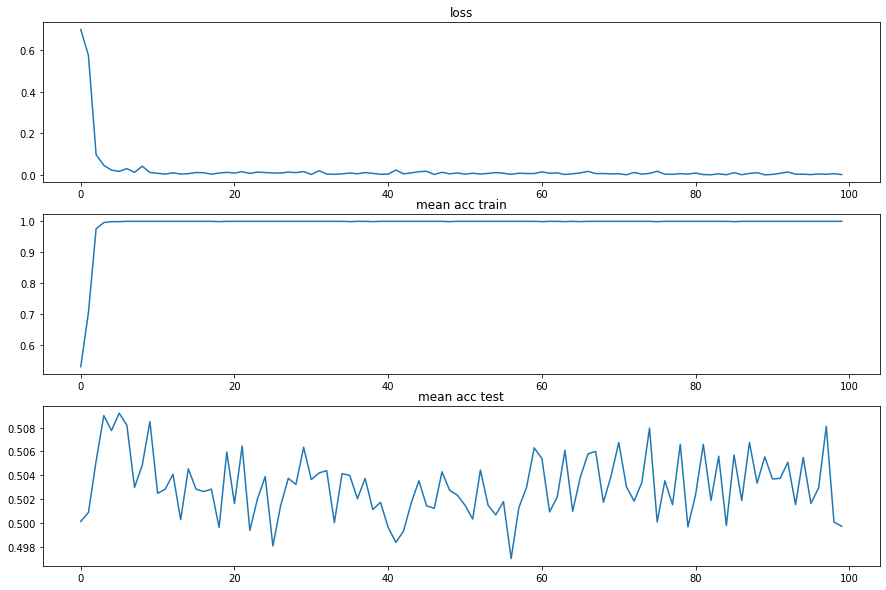

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(311)
plt.plot(list(range(len(losses))), losses)
plt.title('loss')

plt.subplot(312)
plt.plot(list(range(len(mean_accs_train))), mean_accs_train)
plt.title('mean acc train')

plt.subplot(313)
plt.plot(list(range(len(mean_accs_test))), mean_accs_test)
plt.title('mean acc test')
plt.show()

In [ ]:
dpa_net.forward(Trace_train[1:2])

tensor([[0.4599, 0.5058, 0.5189, 0.5072, 0.4765, 0.4732, 0.5038, 0.5112, 0.4950,
         0.4659, 0.4522, 0.5190, 0.5352, 0.5177, 0.5286, 0.4859, 0.4682, 0.5093,
         0.5106, 0.4888, 0.5360, 0.4854, 0.5015, 0.5209, 0.5354, 0.4918, 0.4890,
         0.5137, 0.5243, 0.5204, 0.5142, 0.4907, 0.5171, 0.5223, 0.4857, 0.5012,
         0.4750, 0.5184, 0.4694, 0.5087, 0.5307, 0.4559, 0.4811, 0.5146, 0.5285,
         0.5386, 0.5017, 0.5032, 0.5355, 0.4796, 0.5098, 0.5257, 0.4849, 0.4765,
         0.5013, 0.4869, 0.5020, 0.4704, 0.4776, 0.4497, 0.4859, 0.5013, 0.4864,
         0.4654, 0.4727, 0.5188, 0.5218, 0.5301, 0.5116, 0.5127, 0.5006, 0.4941,
         0.5360, 0.5158, 0.5270, 0.4962, 0.5093, 0.5188, 0.4915, 0.5100, 0.5128,
         0.4860, 0.4912, 0.4886, 0.5437, 0.4763, 0.5219, 0.4996, 0.5272, 0.5156,
         0.4866, 0.4774, 0.4807, 0.5011, 0.5108, 0.4983, 0.4991, 0.4790, 0.4991,
         0.5044, 0.4925, 0.5168, 0.6272, 0.4977, 0.5304, 0.5305, 0.5241, 0.5164,
         0.4729, 0.4974, 0.5

In [ ]:
key_test[:][0]

tensor([1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
        1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
        0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1.,
        1., 0.], device='cuda:0')

In [ ]:
for epoch in range(2000):
      optimizer.zero_grad()

      preds = dpa_net.forward(Trace_train)

      loss_value = loss(preds, key_train)
      loss_value.backward()
      
      optimizer.step()

      if epoch % 50 == 0:
        test_preds = dpa_net.forward(Trace_test)
        output.clear()
        print('epoch', epoch)
        print('loss', loss_value)
        print((test_preds.round() == key_test).float().mean())
        !nvidia-smi

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi